Here we run ordinary CNN model withotu data agumentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import pandas as pd
import seaborn as sn

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [4]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=300)
testLoader = DataLoader(test, shuffle=True, batch_size=300)

In [11]:
from torchsummary import summary
import nnmodel

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = nnmodel.ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             896
       BatchNorm2d-2           [-1, 32, 50, 50]              64
            Conv2d-3           [-1, 64, 25, 25]          18,496
       BatchNorm2d-4           [-1, 64, 25, 25]             128
            Conv2d-5          [-1, 128, 12, 12]          73,856
       BatchNorm2d-6          [-1, 128, 12, 12]             256
            Conv2d-7            [-1, 256, 6, 6]         295,168
       BatchNorm2d-8            [-1, 256, 6, 6]             512
            Linear-9                  [-1, 512]       1,180,160
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 2]             258
          Dropout-14                   

Trene modellen vår her, muligens implementere wandb her for å deploye modellen og se progressjonen og sammenligne med andre modeller samnt data agumentering kan komme med i denne delen av koden?

In [14]:
def plot_metrics_subplot(ax, train_metrics, test_metrics, ylabel, title):
    ax.plot(train_metrics, label='Train')
    ax.plot(test_metrics, label='Test')
    ax.set(xlabel='Epoch', ylabel=ylabel, title=title)
    ax.legend()

def plot_class_metrics_subplot(ax, metrics_1, metrics_2, ylabel, title, label_1, label_2):
    ax.plot(metrics_1, label=label_1)
    ax.plot(metrics_2, label=label_2)
    ax.set(xlabel='Epoch', ylabel=ylabel, title=title)
    ax.legend()

Epoch: 0/30
Train Loss: 0.5699, Train Accuracy: 67.17%
Test Loss: 0.4132, Test Accuracy: 83.71%
Epoch: 1/30
Train Loss: 0.4703, Train Accuracy: 75.22%
Test Loss: 0.3342, Test Accuracy: 86.85%
Epoch: 2/30
Train Loss: 0.4317, Train Accuracy: 77.20%
Test Loss: 0.3410, Test Accuracy: 85.05%
Epoch: 3/30
Train Loss: 0.4142, Train Accuracy: 78.07%
Test Loss: 0.3116, Test Accuracy: 87.79%
Epoch: 4/30
Train Loss: 0.3972, Train Accuracy: 78.49%
Test Loss: 0.2815, Test Accuracy: 88.35%
Epoch: 5/30
Train Loss: 0.3946, Train Accuracy: 79.03%
Test Loss: 0.3196, Test Accuracy: 85.92%
Epoch: 6/30
Train Loss: 0.3920, Train Accuracy: 79.03%
Test Loss: 0.2827, Test Accuracy: 88.65%
Epoch: 7/30
Train Loss: 0.3726, Train Accuracy: 79.88%
Test Loss: 0.3064, Test Accuracy: 86.71%
Epoch: 8/30
Train Loss: 0.3793, Train Accuracy: 79.70%
Test Loss: 0.2702, Test Accuracy: 89.51%
Epoch: 9/30
Train Loss: 0.3520, Train Accuracy: 80.84%
Test Loss: 0.2418, Test Accuracy: 89.49%
Epoch: 10/30
Train Loss: 0.3485, Train A

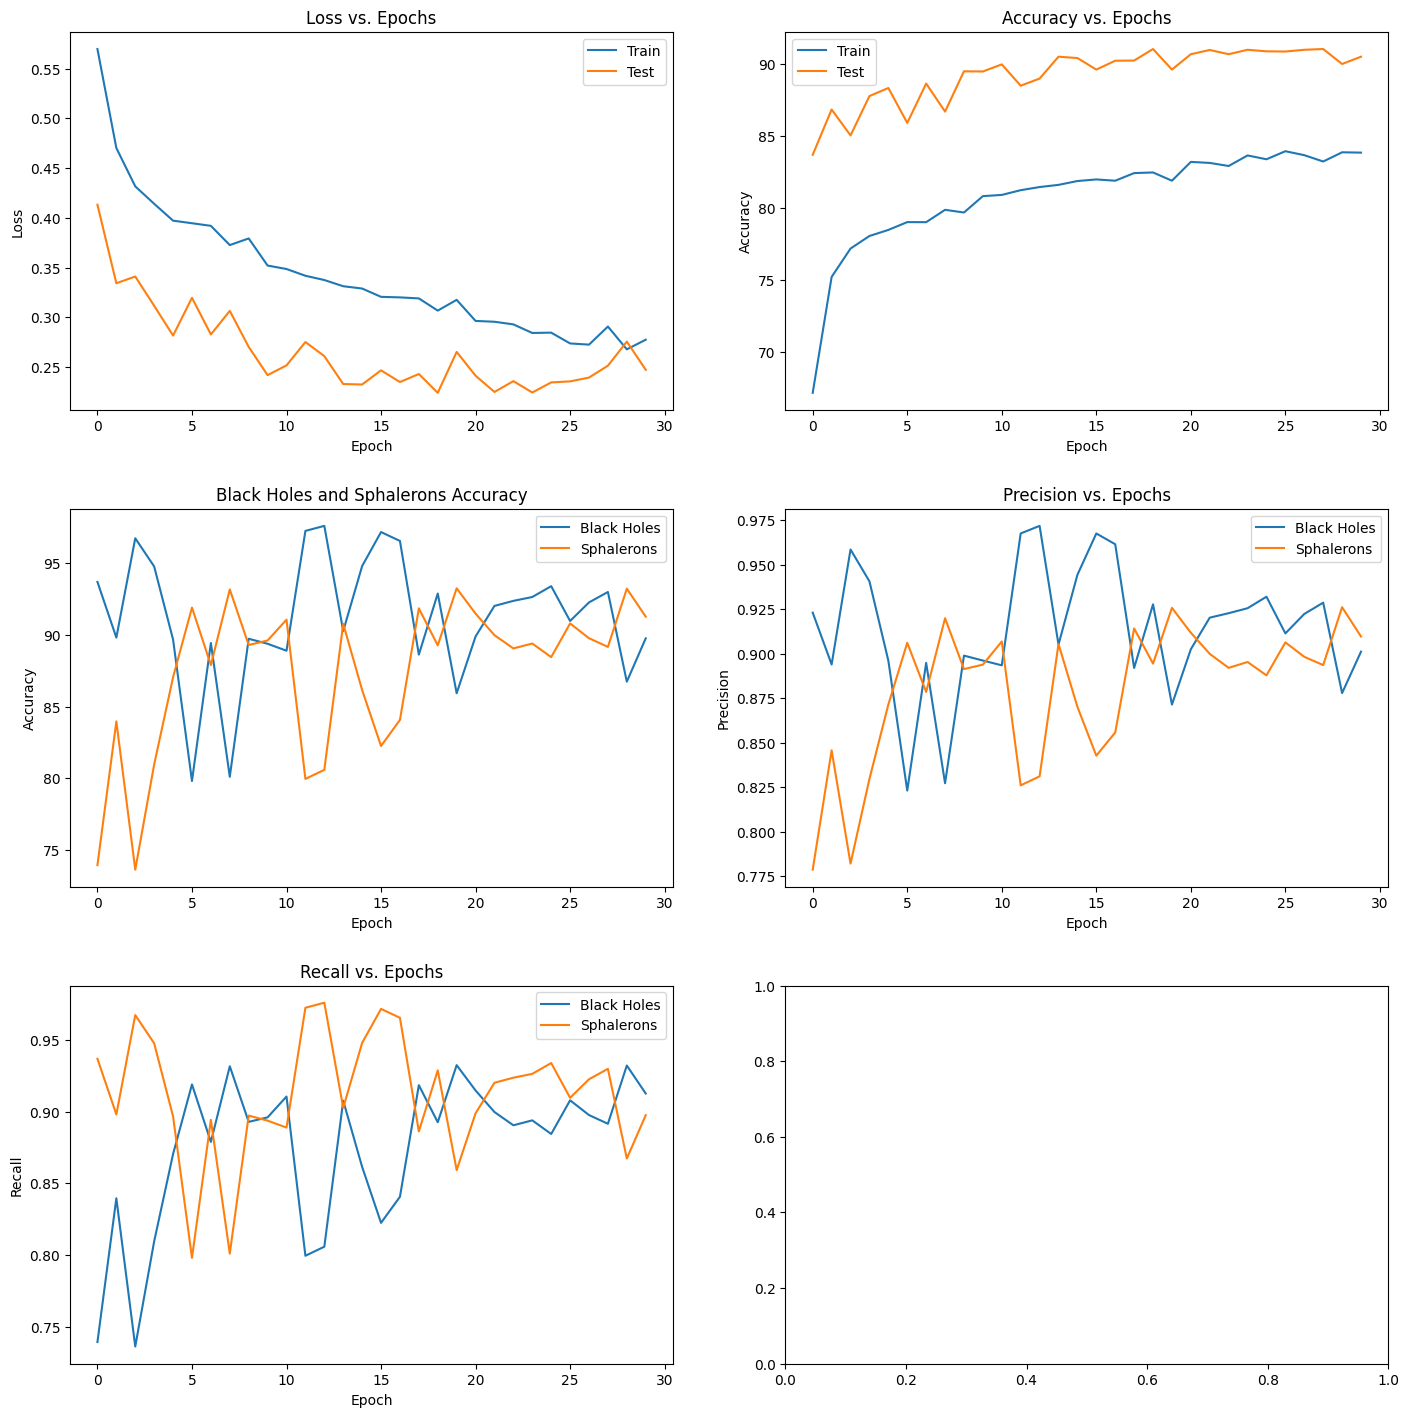

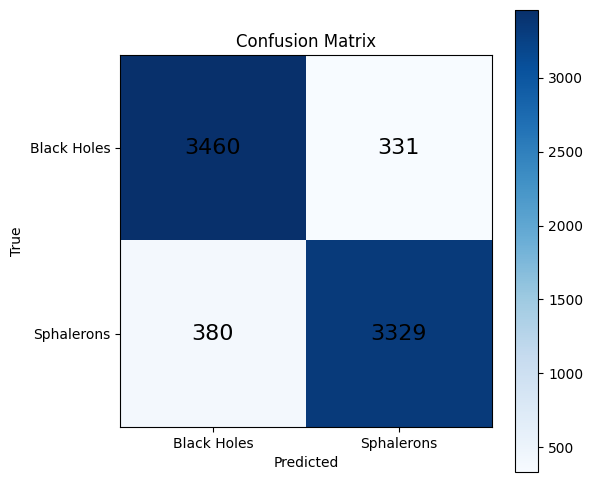

In [18]:
import train 

n_epochs = 30
model = nnmodel.ConvModel1(0.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

results = train.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)

# Plot the metrics
plot_metrics_subplot(axes[0, 0], results['train_losses'], results['test_losses'], 'Loss', 'Loss vs. Epochs')
plot_metrics_subplot(axes[0, 1], results['train_accs'], results['test_accs'], 'Accuracy', 'Accuracy vs. Epochs')
plot_class_metrics_subplot(axes[1, 0], results['black_holes_accs'], results['sphalerons_accs'], 'Accuracy', 'Black Holes and Sphalerons Accuracy', 'Black Holes', 'Sphalerons')

# Plot precision and recall
precisions = [p.tolist() for p in results['precisions']]
recalls = [r.tolist() for r in results['recalls']]
black_holes_precisions = [p[0] for p in precisions]
sphalerons_precisions = [p[1] for p in precisions]
black_holes_recalls = [r[0] for r in recalls]
sphalerons_recalls = [r[1] for r in recalls]

plot_class_metrics_subplot(axes[1, 1], black_holes_precisions, sphalerons_precisions, 'Precision', 'Precision vs. Epochs', 'Black Holes', 'Sphalerons')
plot_class_metrics_subplot(axes[2, 0], black_holes_recalls, sphalerons_recalls, 'Recall', 'Recall vs. Epochs', 'Black Holes', 'Sphalerons')

# Confusion Matrix
cm = confusion_matrix(results["all_labels"], results["all_preds"])
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Black Holes', 'Sphalerons'])
plt.yticks([0, 1], ['Black Holes', 'Sphalerons'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=16)
plt.colorbar()
plt.show()
